In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'leapgestrecog:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F39466%2F61155%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240704%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240704T172320Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da1222b2b873b9f52add41a25f3227d0f85bb790a10be122f82fdc704fdf958836f3b6f8845af8d8779d105a9147cd787341f492f797f5c1004a7b7a06a03dc36d75170b47885edbf62973b3becd6236d4c9a629101e786e506b02c35b07e2979058c71262421e2cc12085b866741f9527aa1cc798a36388da023d40c78979088760d9b3252f1266e3a1cd85bb8a0552d61ef3b8774ab5cc54fae9a2f30d30f9c5e6722ca358229b1fe0baa3925faf22c6c210a02b5cde69d9000b6a6782c4d47273c9936c970f6518e701a177a08077f3bb8698ee61701ca62e64b360459a3b686f11eb5c2a69762d4d17982b4bb28e853723882dcc4f6485d9ba522ddf88f09'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2286085038 bytes downloaded
Downloaded and uncompressed: leapgestrecog
Data source import complete.


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [3]:
DATASET_PATH = "/kaggle/input/leapgestrecog/leapGestRecog"
batch_size = 32
image_size = (128, 128)

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting 20% for validation
)

In [5]:
generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Specify 'training' or 'validation' for either subset
)

Found 16000 images belonging to 10 classes.


In [6]:
validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 4000 images belonging to 10 classes.


In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [8]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 30

In [9]:
history = model.fit(
    generator,

    epochs=epochs,
    validation_data=validation_generator,
)

Epoch 1/30
500/500 [==============================] - 147s 280ms/step - loss: 0.6561 - accuracy: 0.7624 - val_loss: 1.6049 - val_accuracy: 0.6618
Epoch 2/30
500/500 [==============================] - 117s 234ms/step - loss: 0.1089 - accuracy: 0.9613 - val_loss: 1.8616 - val_accuracy: 0.7335
Epoch 3/30
500/500 [==============================] - 135s 270ms/step - loss: 0.0655 - accuracy: 0.9747 - val_loss: 1.0760 - val_accuracy: 0.7660
Epoch 4/30
500/500 [==============================] - 115s 229ms/step - loss: 0.0480 - accuracy: 0.9790 - val_loss: 1.1992 - val_accuracy: 0.7987
Epoch 5/30
500/500 [==============================] - 116s 232ms/step - loss: 0.0478 - accuracy: 0.9791 - val_loss: 1.4164 - val_accuracy: 0.7865
Epoch 6/30
500/500 [==============================] - 117s 233ms/step - loss: 0.0465 - accuracy: 0.9793 - val_loss: 0.7811 - val_accuracy: 0.8440
Epoch 7/30
500/500 [==============================] - 120s 240ms/step - loss: 0.0379 - accuracy: 0.9814 - val_loss: 1.1904 -

In [10]:
test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
print('\nValidation accuracy:', test_acc)

125/125 - 22s - loss: 0.9695 - accuracy: 0.8658 - 22s/epoch - 175ms/step

Validation accuracy: 0.8657500147819519


125/125 [==============================] - 32s 260ms/step


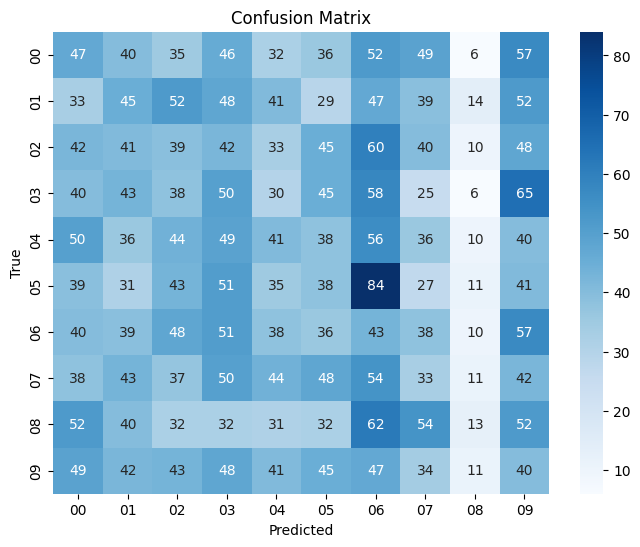

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = model.predict(validation_generator)

# Convert the one-hot encoded predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the one-hot encoded true labels to class labels
y_true_classes = validation_generator.classes
emotion_labels = list(validation_generator.class_indices.keys())

# Create a confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [12]:
from sklearn.metrics import classification_report
# Load the test dataset
X_test, y_test = [], []
for i in range(len(validation_generator)):
    batch_X, batch_y = validation_generator[i]
    X_test.append(batch_X)
    y_test.append(batch_y)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the one-hot encoded true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Create a classification report
report = classification_report(y_true_classes, y_pred_classes)

print(report)

125/125 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       400
           1       1.00      1.00      1.00       400
           2       0.93      0.98      0.96       400
           3       0.86      0.97      0.91       400
           4       0.78      0.73      0.75       400
           5       1.00      0.99      0.99       400
           6       0.67      0.97      0.79       400
           7       0.89      0.78      0.83       400
           8       1.00      0.23      0.37       400
           9       0.80      1.00      0.89       400

    accuracy                           0.87      4000
   macro avg       0.89      0.87      0.85      4000
weighted avg       0.89      0.87      0.85      4000

